##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Embeddings de Palavras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/word_embeddings">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    Ver no TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/pt-br/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Executar no Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/pt-br/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    Ver código fonte no GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/pt-br/tutorials/text/word_embeddings.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Baixar notebook</a>
  </td>
</table>

Este tutorial apresenta embedding de palavras. Ele contém código completo para treinar combinações de palavras do zero em um pequeno conjunto de dados e para visualizá-las usando o [Embedding Projector] (http://projector.tensorflow.org) (mostrado na imagem abaixo).

<img src = "https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt = "Captura de tela do projetor de embedding" width = "400" />

## Representando texto como números

Os modelos de aprendizado de máquina recebem vetores (matrizes de números) como entrada. Ao trabalhar com texto, a primeira coisa que devemos fazer é criar uma estratégia para converter seqüências de caracteres em números (ou "vetorizar" o texto) antes de alimentá-lo no modelo. Nesta seção, examinaremos três estratégias para fazê-lo.

### Codificações one-hot

Como primeira idéia, podemos "codificar" cada palavra em nosso vocabulário. Considere a frase "The cat sat on the mat". O vocabulário (ou palavras únicas) nesta frase é (cat, mat, on, sat, the). Para representar cada palavra, criaremos um vetor de zeros com comprimento igual ao vocabulário e, em seguida, colocaremos 1 no índice que corresponder à palavra. Essa abordagem é mostrada no diagrama a seguir.

<img src = "https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/one-hot.png?raw=1" alt = "Diagrama de codificações únicas" width ="400"/>

Para criar um vetor que contenha a codificação da sentença, poderíamos concatenar o vetor one-hot de cada palavra.

Ponto-chave: Essa abordagem é ineficiente. Um vetor one-hot é escasso (ou seja, a maioria das indicações é zero). Imagine que temos 10.000 palavras no vocabulário. Para codificar cada palavra, criaríamos um vetor em que 99,99% dos elementos são zero.

### Codifique cada palavra com um número único

Uma segunda abordagem que podemos tentar é codificar cada palavra usando um número único. Continuando o exemplo acima, poderíamos atribuir 1 a "cat", 2 a "mat" e assim por diante. Poderíamos então codificar a frase "The cat sat on the mat" como um vetor denso como [5, 1, 4, 3, 5, 2]. Esta abordagem é eficiente. Em vez de um vetor esparso, agora temos um denso (onde todos os elementos estão cheios).

No entanto, existem duas desvantagens nessa abordagem:

* A codificação de número inteiro é arbitrária (não captura nenhuma relação entre palavras).

* Uma codificação de número inteiro pode ser desafiadora para um modelo interpretar. Um classificador linear, por exemplo, aprende um único peso para cada recurso. Como não há relação entre a similaridade de duas palavras e a similaridade de suas codificações, essa combinação de peso e característica não tem significado.

### Embeddings de palavras

O embedding de palavras nos fornece uma maneira de usar uma representação eficiente e densa, na qual palavras semelhantes têm uma codificação semelhante. É importante ressaltar que não precisamos especificar essa codificação manualmente. Um embedding é um vetor denso de valores de ponto flutuante (o comprimento do vetor é um parâmetro que você especifica). Em vez de especificar os valores para o embedding manualmente, eles são parâmetros treináveis ​​(pesos aprendidos pelo modelo durante o treinamento, da mesma maneira que um modelo aprende pesos para uma camada densa). É comum ver combinações de palavras de 8 dimensões (para conjuntos de dados pequenos), com até 1024 dimensões ao trabalhar com conjuntos de dados grandes. Um embedding dimensional mais alto pode capturar relacionamentos refinados entre as palavras, mas exige mais dados para aprender.

<img src = "https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding2.png?raw=1" alt = "Diagrama de um Embedding" width = "400"/>

Acima está um diagrama para um embedding de uma palavra. Cada palavra é representada como um vetor quadridimensional de valores de ponto flutuante. Outra maneira de pensar em um embedding é como "tabela de pesquisa". Depois que esses pesos foram aprendidos, podemos codificar cada palavra procurando o vetor denso a que corresponde na tabela.

## Configuração

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## Usando a camada Embedding

Keras facilita o uso de embedding de palavras. Vamos dar uma olhada na camada [Embedding] (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding).

A camada de embedding pode ser entendida como uma tabela de pesquisa que mapeia de índices inteiros (que significam palavras específicas) a vetores densos (seus embeddings). A dimensionalidade (ou largura) do embedding é um parâmetro com o qual você pode experimentar para ver o que funciona bem para o seu problema, da mesma maneira que você experimentaria com o número de neurônios em uma camada Dense.


In [4]:
embedding_layer = layers.Embedding(1000, 5)

Quando você cria uma camada de embedding, os pesos para a incorporação são inicializados aleatoriamente (como qualquer outra camada). Durante o treinamento, eles são ajustados gradualmente via retropropagação. Uma vez treinadas, as combinações de palavras aprendidas codificam aproximadamente semelhanças entre as palavras (como foram aprendidas para o problema específico em que seu modelo é treinado).

Se você passar um número inteiro para uma camada de embedding, o resultado substituirá cada número inteiro pelo vetor da tabela de embedding:

In [5]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.03503751, -0.0195509 ,  0.01831042, -0.03504615, -0.03742   ],
       [-0.02549988,  0.03117206, -0.04524007,  0.00763919,  0.02982289],
       [-0.01885194, -0.02425988,  0.02199003,  0.04105213, -0.02754666]],
      dtype=float32)

Para problemas de texto ou sequência, a camada Embedding usa um tensor 2D de números inteiros, de forma `(samples, sequence_length)`, onde cada entrada é uma sequência de números inteiros. Pode incorporar seqüências de comprimentos variáveis. Você pode alimentar a camada de embedding acima dos lotes com as formas `(32, 10)` (lote de 32 sequências de comprimento 10) ou `(64, 15)` (lote de 64 sequências de comprimento 15).

O tensor retornado possui mais um eixo que a entrada, os vetores de embedding são alinhados ao longo do novo último eixo. Passe um lote de entrada `(2, 3)` e a saída é `(2, 3, N)`

In [6]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

Quando recebe um lote de seqüências como entrada, uma camada de embedding retorna um tensor de ponto flutuante 3D, de forma `(amostras, comprimento_de_ sequência, dimensão_de_implantação)`. Para converter dessa sequência de comprimento variável para uma representação fixa, há uma variedade de abordagens padrão. Você pode usar uma camada RNN, Attention ou pooling antes de passá-la para uma camada Dense. Este tutorial usa o pool porque é mais simples. O tutorial [Classificação de texto com um RNN] (text_classification_rnn.ipynb) é um bom próximo passo.

## Aprendendo embeddings do zero

Neste tutorial, você treinará um classificador de sentimentos nas críticas de filmes do IMDB. No processo, o modelo aprenderá o embedding do zero. Usaremos para um conjunto de dados pré-processado.

Para carregar um conjunto de dados de texto do zero, consulte o [Carregando texto tutorial] (../ load_data / text.ipynb).

In [7]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteEMZBDA/imdb_reviews-train.tfrecord
Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteEMZBDA/imdb_reviews-test.tfrecord
Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteEMZBDA/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


Obtenha o codificador (`tfds.features.text.SubwordTextEncoder`) e dê uma rápida olhada no vocabulário.

O `\_` no vocabulário representa espaços. Observe como o vocabulário inclui palavras inteiras (terminando com `\_`) e palavras parciais que podem ser usadas para criar palavras maiores

In [8]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

As críticas de filmes podem ter diferentes comprimentos. Usaremos o método `padded_batch` para padronizar os comprimentos das revisões.

In [9]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

Conforme importado, o texto das revisões é codificado por número inteiro (cada número inteiro representa uma palavra específica ou parte da palavra no vocabulário).

Observe os zeros à direita, porque o lote é preenchido no exemplo mais longo.

In [10]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[  12,  284,   14, ...,    0,    0,    0],
       [7969, 6305,  106, ...,   16,   10,   17],
       [  69,   18, 6065, ...,    0,    0,    0],
       ...,
       [  12,  258, 2599, ...,    0,    0,    0],
       [  62,   32,    9, ...,    0,    0,    0],
       [  62,   32,    9, ...,    0,    0,    0]])

### Crie um modelo simples

Usaremos a [Keras Sequential API] (../../guide/keras) para definir nosso modelo. Nesse caso, é um modelo de estilo "Saco contínuo de palavras".

* Em seguida, a camada Embedding pega o vocabulário codificado por número inteiro e procura o vetor de embedding para cada índice de palavras. Esses vetores são aprendidos à medida que o modelo treina. Os vetores adicionam uma dimensão à matriz de saída. As dimensões resultantes são: `(lote, sequência, incorporação)`.

* Em seguida, uma camada GlobalAveragePooling1D retorna um vetor de saída de comprimento fixo para cada exemplo calculando a média sobre a dimensão de sequência. Isso permite que o modelo lide com entradas de comprimento variável, da maneira mais simples possível.

* Esse vetor de saída de comprimento fixo é canalizado através de uma camada totalmente conectada (dense) com 16 unidades ocultas.

* A última camada está densamente conectada com um único nó de saída. Usando a função de ativação sigmóide, esse valor é um valor flutuante entre 0 e 1, representando uma probabilidade (ou nível de confiança) de que a revisão seja positiva.

Cuidado: Este modelo não usa mascaramento; portanto, o preenchimento zero é usado como parte da entrada; portanto, o comprimento do preenchimento pode afetar a saída. Para corrigir isso, consulte o [guia de máscara e preenchimento] (../../guide/keras/masking_and_padding).

In [11]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


### Compile e treine o modelo

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6231 - accuracy: 0.6409 - val_loss: 0.4263 - val_accuracy: 0.8100
Epoch 2/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.3036 - accuracy: 0.8876 - val_loss: 0.3357 - val_accuracy: 0.8650
Epoch 3/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.2434 - accuracy: 0.9130 - val_loss: 0.4356 - val_accuracy: 0.8400
Epoch 4/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.2046 - accuracy: 0.9270 - val_loss: 0.3703 - val_accuracy: 0.8650
Epoch 5/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1827 - accuracy: 0.9354 - val_loss: 0.3637 - val_accuracy: 0.8350
Epoch 6/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1643 - accuracy: 0.9412 - val_loss: 0.5068 - val_accuracy: 0.8600
Epoch 7/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.1445 - accuracy: 0.9523 - val_loss: 0.4818 - val_accuracy:

Com essa abordagem, nosso modelo alcança uma acurácia de validação de cerca de 88% (observe que o modelo está adaptado demais (overfitting), a precisão do treinamento é significativamente maior).

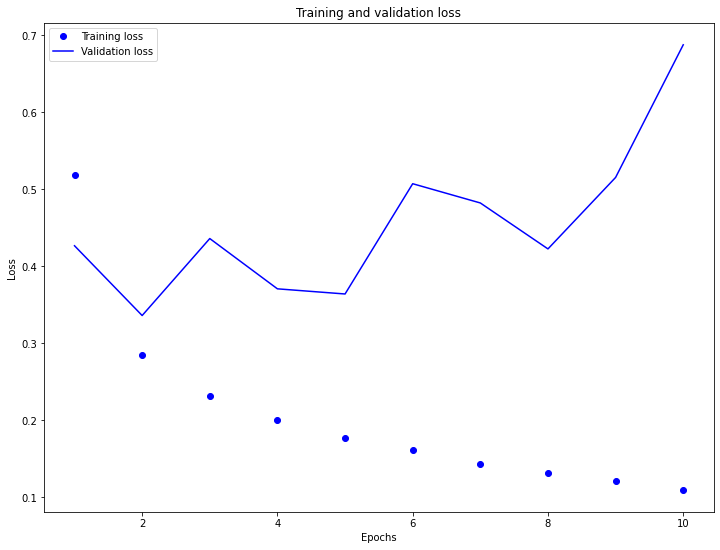

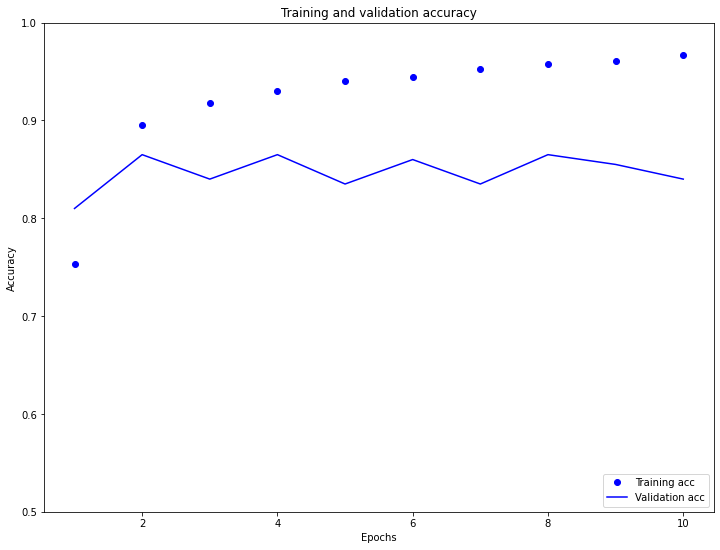

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

## Recuperar os embeddings aprendidos

Em seguida, vamos recuperar o embedding da palavra aprendida durante o treinamento. Esta será uma matriz de forma `(vocab_size, embedding-dimension)`.

In [14]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # formato: (vocab_size, embedding_dim)

(8185, 16)


Vamos agora escrever os pesos no disco. Para usar o [Embedding Projector] (http://projector.tensorflow.org), enviaremos dois arquivos em formato separado por tabulação: um arquivo de vetores (contendo a incorporação) e um arquivo de metadados (contendo as palavras).

In [15]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # pule o 0, está preenchido.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

Se você estiver executando este tutorial em [Colaboratory] (https://colab.research.google.com), poderá usar o seguinte trecho para fazer o download desses arquivos na máquina local (ou usar o navegador de arquivos, * Exibir -> Tabela de conteúdo -> Navegador de arquivos *).

In [16]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Visualize os embeddings

Para visualizar nossos embeddings, nós os carregaremos no projetor de embeddings.

Abra o [Embedding Projector] (http://projector.tensorflow.org/) (isso também pode ser executado em uma instância local do TensorBoard).

* Clique em "Carregar dados".

* Carregue os dois arquivos que criamos acima: `vecs.tsv` e` meta.tsv`.

Os embeddings que você treinou agora serão exibidas. Você pode procurar por palavras para encontrar os vizinhos mais próximos. Por exemplo, tente pesquisar por "beautiful". Você pode ver vizinhos como "wonderful".

Nota: seus resultados podem ser um pouco diferentes, dependendo de como os pesos foram inicializados aleatoriamente antes de treinar a camada de embedding.

Nota: experimentalmente, você poderá produzir combinações mais interpretáveis ​​usando um modelo mais simples. Tente excluir a camada `Dense (16)`, treinar novamente o modelo e visualizar os encaixes novamente.

<img src = "https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt = "Captura de tela do projetor de embedding" width = "400" />

## Próximos passos


Este tutorial mostrou como treinar e visualizar o embedding de palavras do zero em um pequeno conjunto de dados.

* Para aprender sobre redes recorrentes, consulte o [Guia Keras RNN] (../../guide/keras/rnn.ipynb).

* Para saber mais sobre a classificação de texto (incluindo o fluxo de trabalho geral e se você está curioso para saber quando usar combinações versus codificações únicas), recomendamos esta prática guia de classificação de texto (https://developers.google.com/machine-learning/guides/text-classification/step-2-5).